### Train FOMO on the LOAF dataset

this notebook was corrected to work in this enviroment (different paths), training runs were stopped early to save time and not overwrite the original models used in the paper. 

In [1]:
import os
import sys
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization, Conv2D, DepthwiseConv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
from DatasetLoader import DatasetLoader as dl
from save_info import save_model_info

The original fomo model

In [2]:
def build_model(input_shape: tuple, weights: str, alpha: float,
                num_classes: int) -> tf.keras.Model:
    """ Construct a constrained object detection model.

    Args:
        input_shape: Passed to MobileNet construction.
        weights: Weights for initialization of MobileNet where None implies
            random initialization.
        alpha: MobileNet alpha value.
        num_classes: Number of classes, i.e. final dimension size, in output.

    Returns:
        Uncompiled keras model.

    Model takes (B, H, W, C) input and
    returns (B, H//8, W//8, num_classes) logits.
    """

    #! First create full mobile_net_V2 from (HW, HW, C) input
    #! to (HW/8, HW/8, C) output
    mobile_net_v2 = MobileNetV2(input_shape=input_shape,
                                weights=weights,
                                alpha=alpha,
                                include_top=True)
    #! Default batch norm is configured for huge networks, let's speed it up
    for layer in mobile_net_v2.layers:
        if type(layer) == BatchNormalization:
            layer.momentum = 0.9
    #! Cut MobileNet where it hits 1/8th input resolution; i.e. (HW/8, HW/8, C)
    cut_point = mobile_net_v2.get_layer('block_6_expand_relu')
    #! Now attach a small additional head on the MobileNet
    model = Conv2D(filters=32, kernel_size=1, strides=1,
                activation='relu', name='head')(cut_point.output)
    logits = Conv2D(filters=num_classes, kernel_size=1, strides=1,
                    activation=None, name='logits')(model)

    return Model(inputs=mobile_net_v2.input, outputs=logits)

Load the models in, rgb images so we can use mobilenet weights

In [3]:
models = []
sizes = [96, 128, 224]
a = [0.35, 0.75]
names = []

for j in a:
    for i in sizes:
        models.append(build_model((i, i, 3), "imagenet", j, 2))
        #commented to not save multiple copies
        #save_model_info(name=f"fomo_a{str(j).replace('.', '')}_r{i}", model=models[-1], path="model_info.yaml")
        names.append(f"fomo_a{str(j).replace('.', '')}_r{i}")

#### 2. Create datasets

In [ ]:
datasets = []
train_ds = []

val_datasets = []
val_ds = []

counts = []
dl_loaders = []

for r in range(len(sizes)):
    dl_loaders.append(dl("RGB", "fomo-obj", sizes[r]))

    ds, c = dl_loaders[-1].get_dataset("train_loaf")
    datasets.append(ds.shuffle(c, reshuffle_each_iteration=True))
    counts.append(c)

    train_ds.append((datasets[-1]
        .shuffle(c)
        .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=True), 
                num_parallel_calls=tf.data.AUTOTUNE)
        .batch(64)
        .prefetch(tf.data.AUTOTUNE)))

    ds, c = dl_loaders[-1].get_dataset("test_loaf")
    val_datasets.append(ds)
    val_ds.append((val_datasets[-1]
        .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=False), 
                num_parallel_calls=tf.data.AUTOTUNE)
        .batch(64)
        .prefetch(tf.data.AUTOTUNE)))

Check if the random flip and brightness works

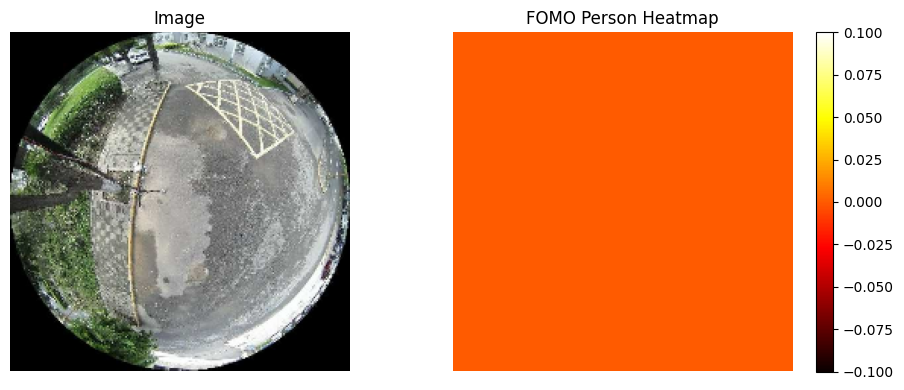

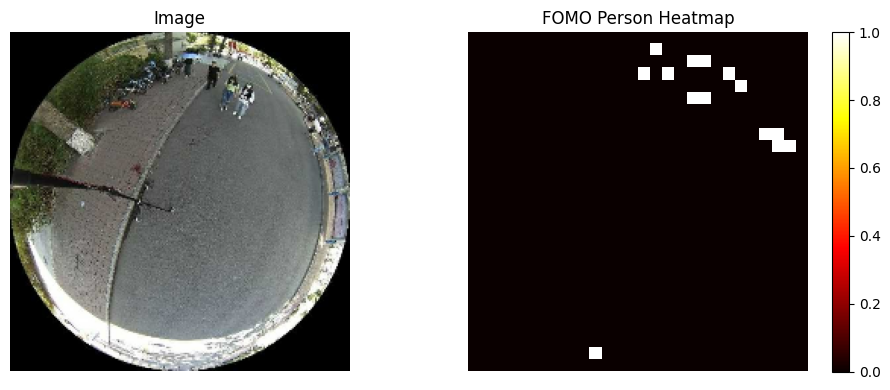

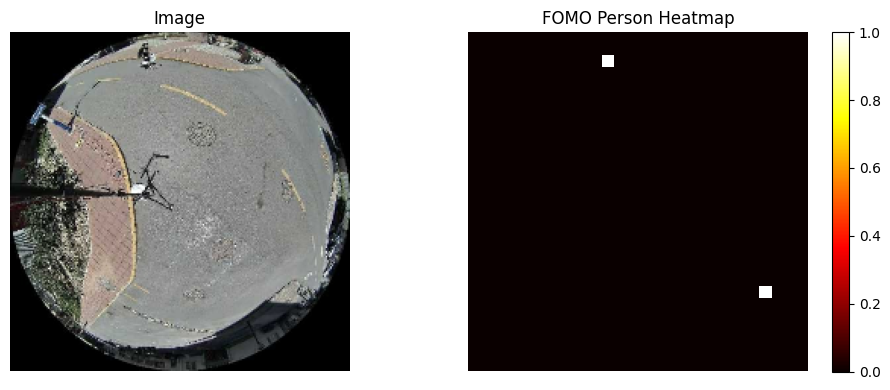

In [9]:
for images, anns in train_ds[-1].take(1):
    break

def show_fomo_sample(image, ann, idx=0):
    img = image[idx].numpy()
    ann_map = ann[idx].numpy()[..., 0]  # class 0 = person

    plt.figure(figsize=(10, 4))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    # Show heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(ann_map, cmap="hot", interpolation="nearest")
    plt.title("FOMO Person Heatmap")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show the first 3 examples
for i in range(3):
    show_fomo_sample(images, anns, idx=i)

Now before going further we need to compile the model. FOMO uses and adam optimizer and a weighted xent (cross entropy loss) with a weight of 100.

In [10]:
import model_loss
for i in range(len(models)):
    weighted_xent = model_loss.construct_weighted_xent_fn(models[i].output.shape)
    models[i].compile(loss=weighted_xent,
                        optimizer="adam")

lets evaluate the models before training

In [11]:
model_to_ds = {"r96": [train_ds[0], val_ds[0]],
               "r128": [train_ds[1], val_ds[1]],
               "r224": [train_ds[2], val_ds[2]]}

loss = np.zeros(len(models))

for i in range(len(models)):
    for n, ds in model_to_ds.items():
        if n in names[i]:
            loss[i] = models[i].evaluate(ds[-1])
            break


138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 100.9438
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 13.8407
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 94.4103
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 10.9985
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 18.7448
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 55.7447


Now lets train the model

In [ ]:
NUM_EPOCHS = 40

lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1,
                                                 mode='auto', min_delta=0.0005, cooldown=0, min_lr=0)
checkpoint_filepath = []

count = 0


for j in a:
    for i in sizes:
        checkpoint_filepath.append(f"out_loaf/fomoloaf_a{str(j).replace('.', '')}_r{i}.keras")
        print(checkpoint_filepath[-1])
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath[-1],
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)
        
        start_time = time.time()
        models[count].fit(train_ds[count%3],
                epochs=NUM_EPOCHS,
                validation_data=val_ds[count%3],
                callbacks=[lr_scheduler_callback, model_checkpoint_callback])
        print(f"Total training time = {time.time() - start_time:.2f} seconds")
        
        count += 1

out_loaf/fomoloaf_a035_r96_0.keras
Epoch 1/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - loss: 5.3008 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 2/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.2743 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 3/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.2571 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 4/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.2432 - val_loss: 0.2393 - learning_rate: 0.0010
Epoch 5/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.2320 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 6/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.2231 - val_loss: 0.2450 - learning_rate: 0.0010
Epoch 7/40
463/463 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.2175 - val_loss: 0.2510 - learning_rate: 0.0010
Epoch 8/40
461/463 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2147
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
463/463 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms

KeyboardInterrupt: 

In [14]:
import yaml
import re
import model_loss as ml
RES_FILE = "results_loaf.yaml"

def write_res(file_path, name, new_metrics):

    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, 'r') as file:
            existing_data = yaml.safe_load(file) or {}
    else:
        existing_data = {}

    existing_data[name] = new_metrics

    with open(file_path, 'w') as file:
        yaml.dump(existing_data, file, sort_keys=False)

for i in checkpoint_filepath:
    res = int(re.search(r"r(\d+)", i).group(1))
    name = i.replace("_0", "")
    loss_fn = ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2))
    saved_model = tf.keras.models.load_model(name, compile=True, custom_objects={"weighted_xent": loss_fn})

    loss = saved_model.evaluate(model_to_ds[f"r{str(res)}"][1])
    write_res(RES_FILE, name.replace(".keras", ""), {"loss": loss, "params": saved_model.count_params()})

138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.2403
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.1510
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0577
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.2223
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1438
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0567


ValueError: File not found: filepath=out_loaf/fomoloaf_a035_r96_1.keras. Please ensure the file is an accessible `.keras` zip file.